In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_PATH =  '../../../data/cluster/year/'
HISTORIC_DATA_PATH = '../../../data/cluster/historic/'
[f for f in os.listdir(DATA_PATH) if 'full' in f]

['X_test_full.csv',
 'X_train_full.csv',
 'X_valid_full.csv',
 'y_test_full.csv',
 'y_train_full.csv',
 'y_valid_full.csv']

In [3]:
X_train = pd.read_csv(DATA_PATH + 'X_train_full.csv')
X_valid = pd.read_csv(DATA_PATH + 'X_valid_full.csv')
X_test  = pd.read_csv(DATA_PATH + 'X_test_full.csv')
y_train = pd.read_csv(DATA_PATH + 'y_train_full.csv')
y_valid = pd.read_csv(DATA_PATH + 'y_valid_full.csv')
y_test  = pd.read_csv(DATA_PATH + 'y_test_full.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_valid = X_valid.drop(['Unnamed: 0'], axis=1)
X_test  = X_test.drop(['Unnamed: 0'],  axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_valid = y_valid.drop(['Unnamed: 0'], axis=1)
y_test  = y_test.drop(['Unnamed: 0'],  axis=1)


print('train: X %s\t y%s' % (X_train.shape, y_train.shape))
print('valid: X %s\t y%s' % (X_valid.shape, y_valid.shape))
print('test:  X %s\t y%s' % (X_test.shape,  y_test.shape))

train: X (529623, 25)	 y(529623, 1)
valid: X (117694, 25)	 y(117694, 1)
test:  X (117694, 25)	 y(117694, 1)


In [4]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.23%
Percent presence in y_valid: 13.29%
Percent presence in y_test: 12.54%


In [5]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [6]:
np.isfinite(X_valid).all()

year                        True
meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
studyArea                   True
elev_srtm30                 True
x                           True
y                           True
next_year_beetle            True
dtype: bool

In [7]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

(527766, 25) (527766, 1)
(116732, 25) (116732, 1)
(117472, 25) (117472, 1)


In [8]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [9]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_test  = X_test.drop(['studyArea',  'x', 'y', 'elev_srtm30', 'year'],  axis=1)

In [10]:
predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']


In [11]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [12]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [16]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = np.logspace(-4, 0, 10)

t0 = time.time()
for C in Cs:
    print('Testing C =', C)
    for penalty in ['l1', 'l2']:
        print('  %s:' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_train, y_train)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        print(accuracy)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        #print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.0001
  l1: 0.92923962581
  l2: 0.929291025597
Testing C = 0.000278255940221
  l1: 0.929453791591
  l2: 0.929248192441
Testing C = 0.000774263682681
  l1: 0.929642257479
  l2: 0.929350992016
Testing C = 0.00215443469003
  l1: 0.929702223897
  l2: 0.929573724429
Testing C = 0.00599484250319
  l1: 0.929667957372
  l2: 0.929625124216
Testing C = 0.016681005372
  l1: 0.929573724429
  l2: 0.929573724429
Testing C = 0.0464158883361
  l1: 0.929539457904
  l2: 0.929539457904
Testing C = 0.129154966501
  l1: 0.929496624747
  l2: 0.92951375801
Testing C = 0.35938136638
  l1: 0.929505191379
  l2: 0.929505191379
Testing C = 1.0
  l1: 0.929505191379
  l2: 0.92951375801


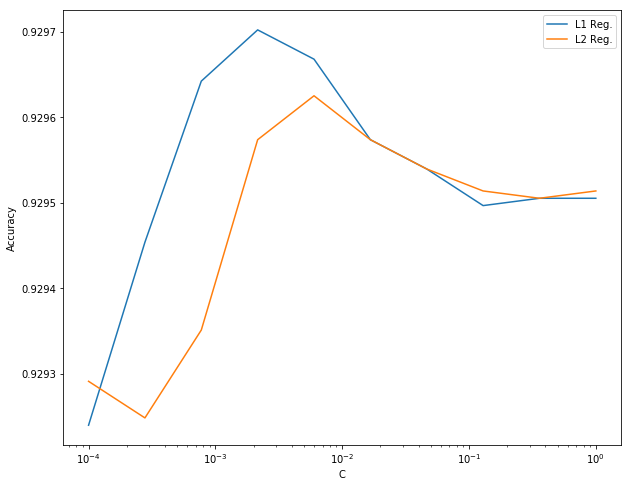

In [17]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [20]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = np.logspace(-3.111, -1.778, 10)

t0 = time.time()
for C in Cs:
    print('Testing C =', C)
    for penalty in ['l1', 'l2']:
        print('  %s:' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_train, y_train)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        print(accuracy)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        #print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.000774461797803
  l1: 0.929642257479
  l2: 0.929350992016
Testing C = 0.00108920872389
  l1: 0.929702223897
  l2: 0.92951375801
Testing C = 0.00153187109752
  l1: 0.929693657266
  l2: 0.929548024535
Testing C = 0.00215443469003
  l1: 0.929702223897
  l2: 0.929573724429
Testing C = 0.00303001266955
  l1: 0.929659390741
  l2: 0.929625124216
Testing C = 0.00426143192928
  l1: 0.929659390741
  l2: 0.929667957372
Testing C = 0.00599330896215
  l1: 0.929667957372
  l2: 0.929625124216
Testing C = 0.00842903345916
  l1: 0.929633690847
  l2: 0.929625124216
Testing C = 0.0118546541659
  l1: 0.929573724429
  l2: 0.929599424322
Testing C = 0.0166724721255
  l1: 0.929573724429
  l2: 0.929573724429


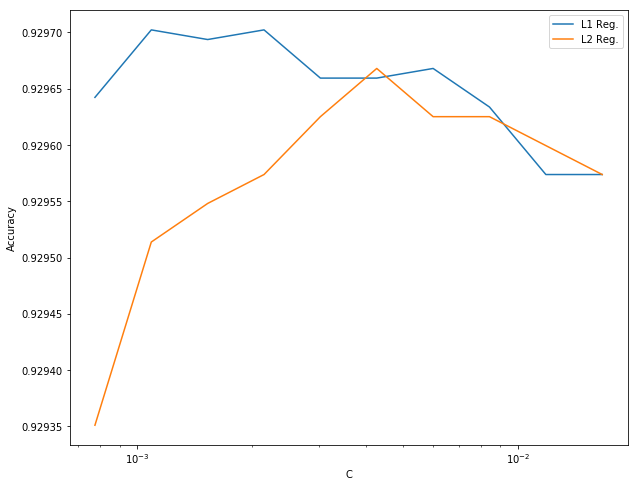

In [21]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [22]:
logistic_clf = LogisticRegression(C=0.00215443469003, penalty='l1')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.93199230454916915

In [23]:
def get_predictions_at_threshold(pred_ps, threshold):
    return 1 * (pred_ps >= threshold)

def threshold_plot(pred_ps, targets):
    thresholds = np.linspace(0, 1, 500)
    accuracies = []
    n = len(pred_ps)

    for threshold in thresholds:
        preds = get_predictions_at_threshold(pred_ps, threshold)
        accuracies.append((preds == targets).sum() / n)
        
    plt.plot(thresholds, accuracies);
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_accuracy = max(accuracies)
    plt.plot([optimal_threshold, optimal_threshold], 
             [min(accuracies), max(accuracies)], 
             'r')
    plt.plot([0, 1], [optimal_accuracy, optimal_accuracy], 'r')
    plt.xlabel('Threshold for predicting "Renewal"')
    plt.ylabel('Accuracy')
    plt.show()
    return {'threshold': optimal_threshold, 'accuracy': optimal_accuracy}

[[ 0.99670468  0.00329532]
 [ 0.99703243  0.00296757]
 [ 0.99818212  0.00181788]
 [ 0.99373154  0.00626846]
 [ 0.99420665  0.00579335]]


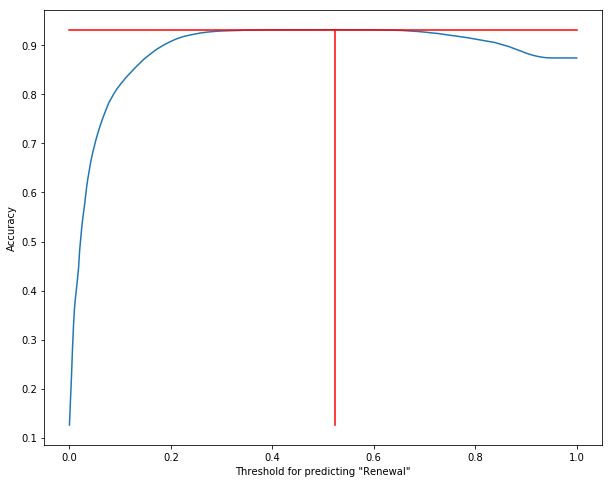

{'threshold': 0.5230460921843687, 'accuracy': 0.93206040588395533}


In [24]:
pred_ps = logistic_clf.predict_proba(X_test)
print(pred_ps[:5])
pred_ps = np.array([p[1] for p in pred_ps])
pred_ps[:5]

THRESHOLD = 0.5
preds = get_predictions_at_threshold(pred_ps, THRESHOLD)
preds[:5]

best_threshold = threshold_plot(pred_ps, y_test);
print(best_threshold)

In [25]:
preds = logistic_clf.predict(X_test)

In [26]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.5)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	10749		4009
        0	3980		98734
Accuracy:  0.931992304549
Precision: 0.729784778328
Recall:    0.72835072503
F1:        0.729067046495


In [27]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.5230460921843687)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	10736		4022
        0	3959		98755
Accuracy:  0.932060405884
Precision: 0.73058863559
Recall:    0.727469846863
F1:        0.72902590568


In [28]:
auc_metrics = util.get_auc(y_test, pred_ps)

AUC:       0.946509033752


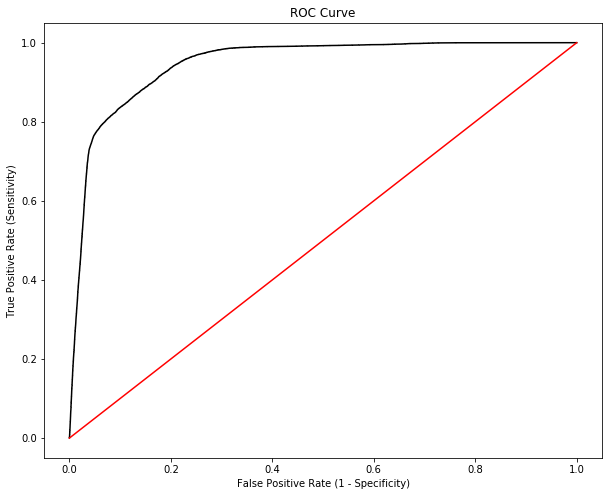

In [29]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [30]:
coefs = pd.DataFrame([[pred, coef] for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
                     columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
19,next_year_beetle,1.168009
10,vegetation,1.042148
7,meanMaxTemp_Aug,1.041926
1,meanTemp_AprAug,-0.837045
5,meanMinTemp_Jan,0.649529
2,meanTemp_Aug,-0.565869
17,lat,0.509030
16,elev_etopo1,0.423889
14,precip_growingSeason,0.355376
8,precip_meanAnnual,-0.333994


In [31]:
def column2matrix(dataframe, column, cell_dim=10000):
    '''                                                                          
    Convert a column from DataFrame df into a matrix representation with the     
    upper-left cell indexing beginning at [0, 0].                                
    It is expected that the DataFrame has columns x and y.                       
                                                                                 
    Args:                                                                        
    df: DataFrame: the source data                                               
    column: string: the column name to extract                                   
    cel_dim: numeric: the dimensions of each grid cell                           
                                                                                 
    Returns: np.ndarray (a 2D list; matrix)                                      
    '''
    df = dataframe.copy()
    x_min = df.x.min()
    y_min = df.y.min()
    df.x -= x_min
    df.y -= y_min
    xs = sorted(df.x.unique())
    ys = sorted(df.y.unique())
    matrix = np.array([[np.nan for y in range(len(ys))]
                       for x in range(len(xs))])

    for row in df.index:
        x, y, value = df.loc[row, ['x', 'y', column]]
        i = int((x - xs[0]) / cell_dim)
        j = int((y - ys[0]) / cell_dim)
        matrix[i, j] = value

    return matrix

In [32]:
full_test['preds'] = preds
full_test.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,elev_etopo1,lat,lon,studyArea,elev_srtm30,x,y,next_year_beetle,beetle,preds
0,2000,17.057845,18.892138,21.608865,4.831345,10.825336,6.119776,7.627907,27.147665,7.199924,...,52,30.505152,-116.039726,1,-2,-1550000.0,-2000000.0,0,0,0
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,17,30.523203,-115.938118,1,17,-1540000.0,-2000000.0,0,0,0
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,151,30.541141,-115.836475,1,74,-1530000.0,-2000000.0,0,0,0
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,500,30.558965,-115.734797,1,466,-1520000.0,-2000000.0,0,0,0
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,564,30.576676,-115.633085,1,568,-1510000.0,-2000000.0,0,0,0


In [33]:
def pred_plot(actual_matrix, pred_matrix, error_matrix, year):
    plt.subplot(131)
    imshow(np.rot90(actual_matrix));
    plt.title('%d Actual' % year);
    plt.subplot(132)
    imshow(np.rot90(pred_matrix));
    plt.title('%d Predicted' % year);
    plt.subplot(133)
    imshow(np.rot90(error_matrix));
    plt.title('%d Error' % year);

In [34]:
def make_actual_pred_and_error_matrices(data, year, plot=False):
    data_year = data.loc[data.year == year, :]
    actual_matrix = column2matrix(data_year, 'beetle')
    pred_matrix   = column2matrix(data_year, 'preds')
    error_matrix  = pred_matrix - actual_matrix
    
    if plot:
        pred_plot(actual_matrix, pred_matrix, error_matrix, year)
        
    return actual_matrix, pred_matrix, error_matrix

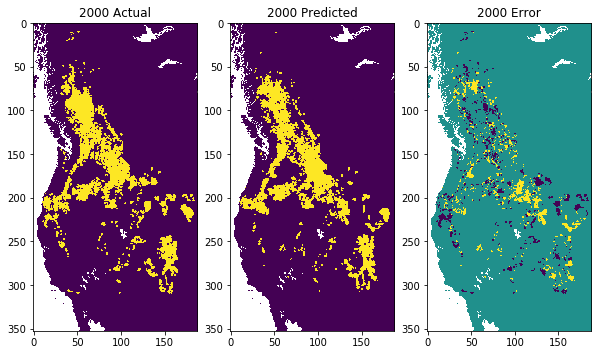

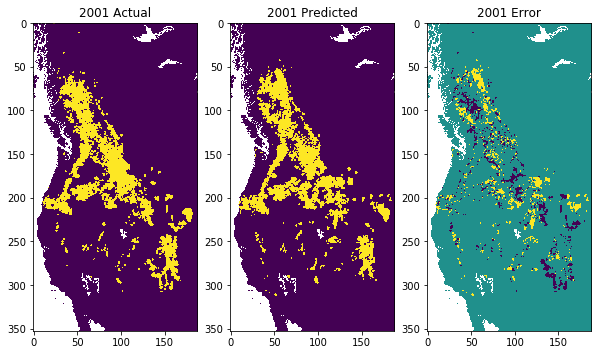

In [35]:
pred_years = [2000, 2001]
for year in pred_years:
    plt.figure();
    make_actual_pred_and_error_matrices(full_test, year, plot=True)

In [36]:
os.listdir(HISTORIC_DATA_PATH)

['.DS_Store', 'clean_1998.csv', 'clean_1999.csv']

In [37]:
def get_ranges(data, verbose=False):
    xrange = data.x.min(), data.x.max()
    yrange = data.y.min(), data.y.max()
    if verbose:
        print('x range:', xrange, '\ny range:', yrange)
    return xrange, yrange

In [38]:
x_range, y_range = get_ranges(full_test, verbose=True)

x range: (-2070000.0, -200000.0) 
y range: (-2000000.0, 1520000.0)


In [42]:
def mask_data(data, xrange, yrange, verbose=False):
    if verbose:
        print('Input data:')
        get_ranges(data, verbose)
    data = data.loc[(data.x >= xrange[0])
                    & (data.x <= xrange[1])
                    & (data.y >= yrange[0])
                    & (data.y <= yrange[1]), :]
    if verbose:
        print('Output data:')
        get_ranges(data, verbose)
    return data

In [43]:
def drop_nans(data, field, verbose=False):
    X = data.copy()
    X = X.loc[np.isnan(X[field]) == False, :]
    if verbose:
        print(X.shape, y.shape)
    return X

In [63]:
historic_years = range(1998, 2000)
year = 1999 # <- !
next_year_data = full_test.loc[full_test.year == (year + 1), :]

hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
hist_data = mask_data(hist_data, x_range, y_range, verbose=True)

hist_merge = hist_data[['x', 'y']]

Input data:
x range: (-5730000.0, 5000000.0) 
y range: (-4510000.0, 4480000.0)
Output data:
x range: (-2070000.0, -200000.0) 
y range: (-2000000.0, 1520000.0)


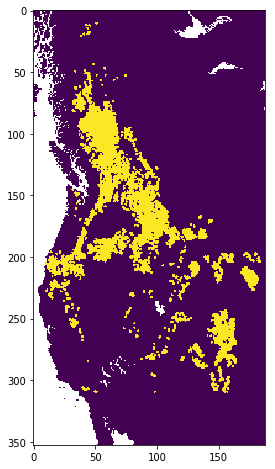

In [46]:
imshow(np.rot90(column2matrix(next_year_data, 'beetle')));

In [47]:
xy = next_year_data.apply(
    lambda row: str(row['x']) + str(row['y']), axis=1)

In [48]:
def find_extra_rows(data, xy):
    remove = []
    for row in data.index:
        data_xy = str(data.loc[row, 'x']) + str(data.loc[row, 'y'])
        if data_xy not in list(xy):
            remove.append(row)
    return remove

In [49]:
extras = find_extra_rows(hist_data, xy)
len(extras)

91

In [50]:
hist_data = hist_data.drop(extras, axis=0)
hist_data = hist_data.rename(
    columns={'precipPreious_OctSep': 'precipPrevious_OctSep'})
print(next_year_data.shape)

(58756, 27)


In [51]:
assert list(hist_data.x) == list(next_year_data.x)
assert list(hist_data.y) == list(next_year_data.y)

In [52]:
hist_data.index = next_year_data.index

In [53]:
print(hist_data.shape)
print(len(next_year_data['beetle']))

(58756, 22)
58756


In [54]:
#list(hist_data)

In [55]:
hist_data['next_year_beetle'] = next_year_data['beetle']
#hist_essential['next_year_beetle'] = next_year_data['beetle']
#imshow(np.rot90(column2matrix(hist_data, 'next_year_beetle')));
hist_essentials = pd.DataFrame(hist_data[predictors[0]])
for p in predictors[1:]:
    hist_essentials[p] = hist_data[p]

hist_essentials.head() 

,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,precip_JunAug,vegetation,precipPrevious_JunAug,precip_OctSep,precipPrevious_OctSep,precip_growingSeason,varPrecip_growingSeason,elev_etopo1,lat,lon,next_year_beetle
0,15.602269,17.043553,20.450920,4.002154,8.870124,5.713369,6.440989,26.268693,3.569788,4.673908,0,2.262533,273.108611,230.271149,11.946349,1.423028,52,30.505152,-116.039726,0
1,15.802161,17.255634,20.671149,4.107497,9.086548,5.811246,6.670581,26.478177,2.620590,2.958697,0,2.033822,256.542815,225.095741,10.556525,1.448678,17,30.523203,-115.938118,0
2,16.227222,17.887257,21.491630,3.915923,9.103102,5.610222,6.650329,27.738199,2.159113,6.173574,0,3.768936,248.747855,222.838494,9.174845,1.480682,151,30.541141,-115.836475,0
3,15.110016,16.998226,21.012175,2.579276,7.565246,4.211151,4.927163,27.898682,6.515173,29.650197,0,13.457667,360.251429,282.069357,18.777443,0.944476,500,30.558965,-115.734797,0
4,15.321903,17.448047,21.631819,2.254531,7.451563,3.817779,4.737033,28.959027,6.309332,35.674847,0,16.249203,353.847053,278.135072,17.231169,0.887878,564,30.576676,-115.633085,0


In [56]:
#print(hist_essential.shape)
#hist_essential = drop_nans(hist_essential, 'next_year_beetle')
#print(hist_essential.shape)

In [57]:
print(predictors)
print(list(hist_essentials))

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']
['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']


In [58]:
hist_essentials = scaler.fit_transform(hist_essentials)

In [59]:
hist_data['preds'] = logistic_clf.predict(hist_essentials)

In [96]:
probs = logistic_clf.predict_proba(hist_essentials)
probs = [prob[1] for prob in probs]
hist_data['probs'] = probs

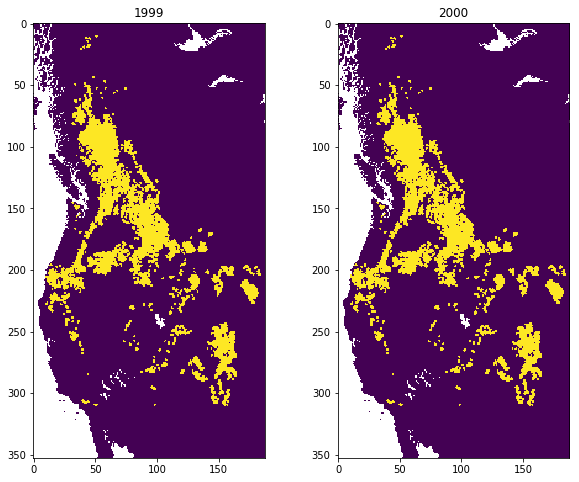

In [60]:
plt.subplot(121);
imshow(np.rot90(column2matrix(hist_data, 'preds')));
plt.title('1999');
plt.subplot(122);
imshow(np.rot90(column2matrix(hist_data, 'next_year_beetle')));
plt.title('2000');

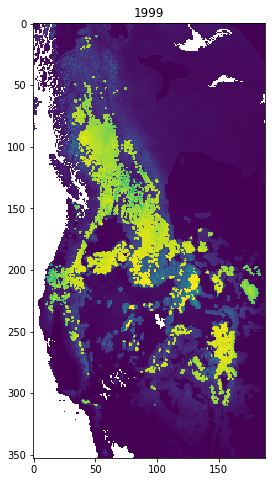

In [97]:
imshow(np.rot90(column2matrix(hist_data, 'probs')));
plt.title('1999');

In [61]:
m_1999 = column2matrix(hist_data, 'preds')
m_2000 = column2matrix(hist_data, 'next_year_beetle')

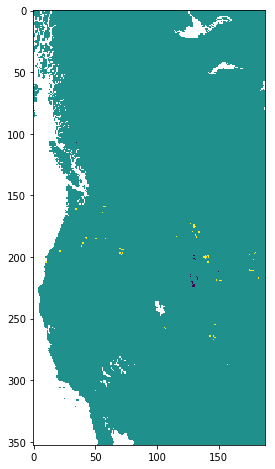

In [62]:
m_diff = m_2000 - m_1999
imshow(np.rot90(m_diff));

In [98]:
historic_years = range(1998, 2000)
year = 1999 # <- !

next_year_data = full_test.loc[full_test.year == (year + 1), :]

hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
hist_data = mask_data(hist_data, x_range, y_range, verbose=False)

hist_merge = hist_data[['x', 'y']]

while year >= historic_years[0]:
    print('\nBeginning predictions for', year)
    xy = next_year_data.apply(
        lambda row: str(row['x']) + str(row['y']), axis=1)
    print('  Reducing %d data to study area...' % year)
    extras = find_extra_rows(hist_data, xy)
    hist_data = hist_data.drop(extras, axis=0)
    hist_data = hist_data.rename(
        columns={'precipPreious_OctSep': 'precipPrevious_OctSep'})
    if year == historic_years[-1]:
        hist_merge = hist_data[['x', 'y']]
    print('  Ascertaining rows are aligned...')
    assert list(hist_data.x) == list(next_year_data.x)
    assert list(hist_data.y) == list(next_year_data.y)
    
    hist_data.index = next_year_data.index
    hist_merge.index = hist_data.index
    hist_data['next_year_beetle'] = next_year_data['beetle'] # 
    hist_essentials = pd.DataFrame(hist_data[predictors[0]])
    print('  Keeping essentials...')
    for p in predictors[1:]:
        hist_essentials[p] = hist_data[p]

    hist_essentials = scaler.fit_transform(hist_essentials)
    hist_data['beetle'] = logistic_clf.predict(hist_essentials)
    print('  Predicting...')
    hist_merge['preds_%d' % year] = hist_data['beetle']

    probs = logistic_clf.predict_proba(hist_essentials)
    probs = [prob[1] for prob in probs]
    hist_merge['probs_%d' % year] = probs
    
    year -= 1
    next_year_data = hist_data
    
hist_merge.head()


Beginning predictions for 1999
  Reducing 1999 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...

Beginning predictions for 1998


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  Reducing 1998 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...


,x,y,preds_1999,probs_1999,preds_1998,probs_1998
0,-1550000.0,-2000000.0,0,0.002232,0,0.002236
1,-1540000.0,-2000000.0,0,0.002120,0,0.002124
2,-1530000.0,-2000000.0,0,0.002273,0,0.002277
3,-1520000.0,-2000000.0,0,0.004436,0,0.004444
4,-1510000.0,-2000000.0,0,0.004809,0,0.004818


In [99]:
m_1999 = column2matrix(hist_merge, 'preds_1999')
m_1998 = column2matrix(hist_merge, 'preds_1998')

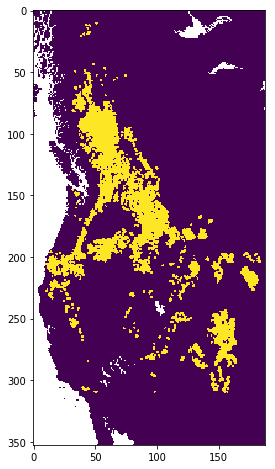

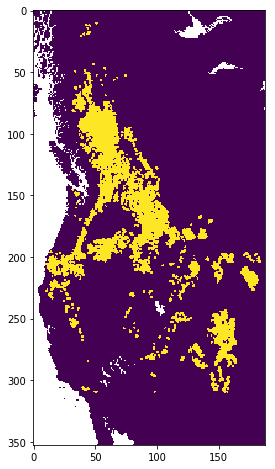

In [100]:
plt.figure();
imshow(np.rot90(m_1999));
plt.figure();
imshow(np.rot90(m_1998));

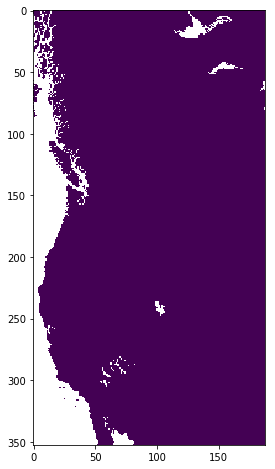

In [86]:
m_diff = m_1999 - m_1998
imshow(np.rot90(m_diff));

In [101]:
m_1999 = column2matrix(hist_merge, 'probs_1999')
m_1998 = column2matrix(hist_merge, 'probs_1998')

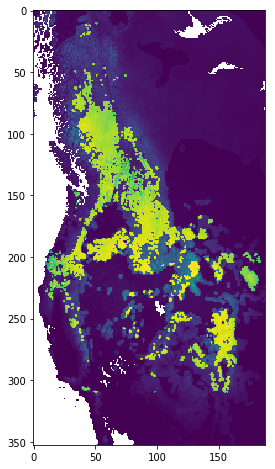

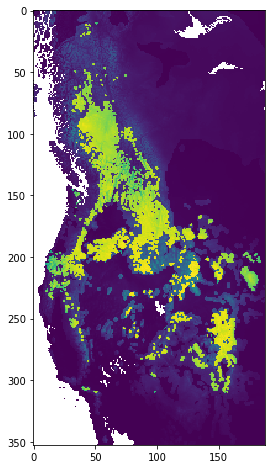

In [102]:
plt.figure();
imshow(np.rot90(m_1999));
plt.figure();
imshow(np.rot90(m_1998));